In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Layer, MultiHeadAttention, LayerNormalization, Add, Reshape
from tensorflow.keras.applications import MobileNet, ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
import kagglehub

# Téléchargement du dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Chemin des données :", path)

# Définition des répertoires
train_dir = os.path.join(path, 'chest_xray/train')
val_dir = os.path.join(path, 'chest_xray/val')
test_dir = os.path.join(path, 'chest_xray/test')

# Paramètres
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Chemin des données : /kaggle/input/chest-xray-pneumonia


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [4]:
# --- Test generator ---
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Test samples: {test_generator.samples}, Classes: {test_generator.num_classes}")


Found 624 images belonging to 2 classes.
Test samples: 624, Classes: 2


In [5]:
folder_path = "/content/drive/MyDrive/chest_dl/finetuning"

In [6]:
# --- Scan folder for models ---
model_files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
print("Models found:")
for f in model_files:
    print(f"- {f}")


Models found:
- best_MobileNet_optimized.h5
- best_ResNet50_optimized.h5
- best_VGG16_optimized.h5
- best_Hybrid_ViT_optimized.h5



Loading model: best_MobileNet_optimized.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 690ms/step
best_MobileNet_optimized.h5 -> Accuracy: 0.9071, AUC-ROC: 0.9653

Loading model: best_ResNet50_optimized.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 479ms/step
best_ResNet50_optimized.h5 -> Accuracy: 0.8446, AUC-ROC: 0.9111

Loading model: best_VGG16_optimized.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 620ms/step
best_VGG16_optimized.h5 -> Accuracy: 0.9247, AUC-ROC: 0.9830

Loading model: best_Hybrid_ViT_optimized.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 603ms/step
best_Hybrid_ViT_optimized.h5 -> Accuracy: 0.8189, AUC-ROC: 0.9043


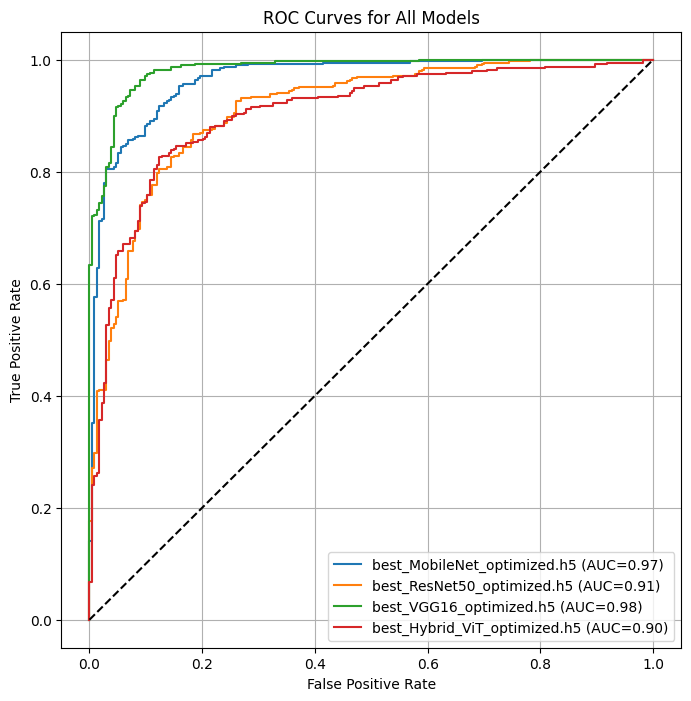

In [7]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os

# --- Define the custom layer if you have it in any model ---

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)  # pass extra args to parent
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# --- Dictionary to store results ---
results = {}
plt.figure(figsize=(8,8))

for model_file in model_files:
    model_path = os.path.join(folder_path, model_file)
    print(f"\nLoading model: {model_file}")

    # --- Load model with custom_objects only if needed ---
    if "Hybrid" in model_file:
        model = load_model(model_path, custom_objects={"TransformerBlock": TransformerBlock})
    else:
        model = load_model(model_path)

    # --- Predict on test set ---
    y_probs = model.predict(test_generator)
    y_pred = (y_probs > 0.5).astype(int).flatten()
    y_true = test_generator.classes

    # --- Accuracy & AUC ---
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)

    print(f"{model_file} -> Accuracy: {acc:.4f}, AUC-ROC: {auc:.4f}")

    # --- Store results ---
    results[model_file] = {'accuracy': acc, 'auc': auc}

    # --- Plot ROC curve ---
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.plot(fpr, tpr, label=f"{model_file} (AUC={auc:.2f})")

# --- Finalize plot ---
plt.plot([0,1],[0,1],'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()
